## Run first cell if in Colab

In [ ]:
# this mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

FOLDERNAME = 'cs231n/cs231n-project/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# # this downloads the CIFAR-10 dataset to your Drive
# # if it doesn't already exist.
# %cd drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
# !bash get_datasets.sh
# %cd /content

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pdb
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

import h5py

import time
import random
import string
from datetime import datetime

import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import save_image
from torchvision.datasets import MNIST
import torch.optim as optim
import os

import math
import seaborn as sns
sns.set(font_scale=2., font="serif", style="whitegrid")
import pandas as pd

from mie2c.e2c import E2C, compute_loss, PWATransition
from mie2c.bounce_model import (get_bounce_encoder, get_bounce_decoder,
    get_bounce_transition, get_bounce_linear_transition, get_bounce_pwa_transition)

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [3]:
def create_img(X, pos_bounds, radius=0.5, W=32):
    x, y, vx, vy = X

    # Check if center of ball outside image frame
    if x < pos_bounds[0] or x > pos_bounds[1]:
        return None
    elif y < pos_bounds[0] or y > pos_bounds[1]:
        return None

    x_px = int(round(W * x / posbounds[1]))
    y_px = int(round(W * y / posbounds[1]))
    r_px = int(round(radius / pos_bounds[1] * W))

    # Check if perimeter of ball outside image frame
    if x_px+r_px > W or x_px-r_px < 0:
        return None
    elif y_px+r_px > W or y_px-r_px < 0:
        return None

    img = np.ones((3,W,W))
    yy,xx = np.mgrid[:W, :W]
    circle = (xx-x_px)**2 + (yy-y_px)**2
    img[:, circle < r_px**2] = 0.

    th = np.arctan2(vy,vx)
    for rr in range(r_px):
        img[0,int(y_px+rr*np.sin(th)), int(x_px+rr*np.cos(th))] = 1.

    return img

In [4]:
def step(x0, Ak, posbounds, rd, add_noise=False):
    # x0: 4D vector (x,y,xd,yd)
    # Ak: 4x4 transition matrix
    # posbounds: [min,max] for x and y
    update = Ak @ x0

    if add_noise:
        mn = np.array([0.1, 0.1])
        cov = np.diag([0.05, 0.05])
        frzn = stats.multivariate_normal(mn, cov)
        update += frzn.rvs(1)

    # Bounce the ball if needed
    if update[0]-rd <= posbounds[0]:
        update[0] = 2*posbounds[0] + 2*rd - update[0]
        update[2] *= -1.
    elif update[0]+rd >= posbounds[1]:
        update[0] = 2*posbounds[1] - 2*rd - update[0]
        update[2] *= -1.

    if update[1]-rd <= posbounds[0]:
        update[1] = 2*posbounds[0] + 2*rd - update[1]
        update[3] *= -1.
    elif update[1]+rd >= posbounds[1]:
        update[1] = 2*posbounds[1] - 2*rd - update[1]
        update[3] *= -1.

    return update

In [9]:
n = 4 
dh = 0.05

rd = 0.5
posbounds = np.array([0,4]) # 4x4m square
velmax = 10.

Ak = np.eye(n)
Ak[0:int(n/2), int(n/2):] = dh * np.eye(int(n/2))

np.random.seed(12)

W = 128

# Training data
NUM_DATA = 500
NUM_STEPS = 10

X = np.zeros((NUM_DATA,6,W,W))
X_next = np.zeros((NUM_DATA,6,W,W))

count, update_count = 0, 0
while count < NUM_DATA:
    if update_count % NUM_STEPS == 0:
        # Restart episode
        x0 = np.hstack((posbounds[1] * np.random.rand(2), velmax*np.ones(2)))
        update_count = 0

    img_prev = create_img(x0, posbounds, radius=rd, W=W)
    if img_prev is None:
        update_count = 0
        continue

    x0 = step(x0, Ak, posbounds, rd)
    img = create_img(x0, posbounds, radius=rd, W=W)
    if img is None:
        update_count = 0
        continue

    x0_new = step(x0, Ak, posbounds, rd)

    img_new = create_img(x0_new, posbounds, radius=rd, W=W)
    if img_new is None:
        update_count = 0
        continue

    X[count,:3,:,:] = img_prev
    X[count,3:,:,:] = img

    X_next[count,:3,:,:] = img
    X_next[count,3:,:,:] = img_new

    x0 = np.copy(x0_new)
    count += 1
    update_count += 1
    
# Training data
NUM_TEST = 100

X_test = np.zeros((NUM_TEST,6,W,W))
X_next_test = np.zeros((NUM_TEST,6,W,W))

count, update_count = 0, 0
while count < NUM_TEST:
    if update_count % NUM_STEPS == 0:
        # Restart episode
        x0 = np.hstack((posbounds[1] * np.random.rand(2), velmax*np.ones(2)))
        update_count = 0

    img_prev = create_img(x0, posbounds, radius=rd, W=W)
    if img_prev is None:
        update_count = 0
        continue

    x0 = step(x0, Ak, posbounds, rd)
    img = create_img(x0, posbounds, radius=rd, W=W)
    if img is None:
        update_count = 0
        continue

    x0_new = step(x0, Ak, posbounds, rd)
    img_new = create_img(x0_new, posbounds, radius=rd, W=W)
    if img_new is None:
        update_count = 0
        continue

    X_test[count,:3,:,:] = img_prev
    X_test[count,3:,:,:] = img

    X_next_test[count,:3,:,:] = img
    X_next_test[count,3:,:,:] = img_new

    x0 = np.copy(x0_new)
    count += 1
    update_count += 1

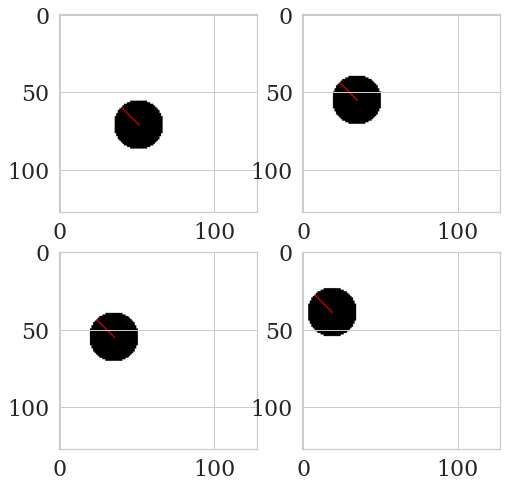

In [15]:
idx = np.random.randint(NUM_DATA)

img_prev, img, img_next_prev, img_next = \
X[idx,:3,:,:], X[idx,3:,:,:], X_next[idx,:3,:,:], X_next[idx,3:,:,:]

fig = plt.figure(figsize=(8,8))

fig.add_subplot(2,2,1)
plt.imshow(img_prev.transpose(1,2,0))

fig.add_subplot(2,2,2)
plt.imshow(img.transpose(1,2,0))

fig.add_subplot(2,2,3)
plt.imshow(img_next_prev.transpose(1,2,0))

fig.add_subplot(2,2,4)
plt.imshow(img_next.transpose(1,2,0))

In [16]:
dim_in = X[0].shape
dim_z = 6
dim_u = 0
use_cuda = False

# Training method

In [17]:
def train_vae(model, X, X_next, model_name, verbose=True, cuda=False):
    if not os.path.exists('pytorch'):
        os.makedirs('pytorch')
    fn_pt_model = 'pytorch/{}.pt'.format(model_name)
    dim_u = model.trans.dim_u

    # training parameters
    TRAINING_ITERATIONS = int(500)
    BATCH_SIZE = int(64)
    CHECKPOINT_AFTER = int(100)
    SAVEPOINT_AFTER = int(200)

    KL_LAMBDA = .25
    TEMP_LAMBDA = 10.

    if cuda:
        dataset = torch.utils.data.TensorDataset(torch.tensor(X).float().to("cuda"), \
                                                 torch.tensor(X_next).float().to("cuda"))
        model = model.to("cuda")
    else:
        dataset = torch.utils.data.TensorDataset(torch.tensor(X).float(), \
                                                 torch.tensor(X_next).float())
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    optimizer = optim.Adam(model.parameters())

    itr = 0
    for epoch in range(TRAINING_ITERATIONS):
        iter_count = 0
        for x, x_next in dataloader:
            optimizer.zero_grad()
            action = torch.empty(NUM_DATA, dim_u)

            model(x, action, x_next)
            elbo_loss, kl_loss = compute_loss(model.x_dec, model.x_next_dec, model.x_next_pred_dec,
                                              x, x_next,
                                              model.Qz, model.Qz_next, model.Qz_next_pred)
            loss = elbo_loss # + KL_LAMBDA * kl_loss
            if isinstance(model.trans, PWATransition):
                loss += TEMP_LAMBDA * model.trans.temperature.pow(2)[0]

            loss.backward()
            optimizer.step()

            if itr % CHECKPOINT_AFTER == 0:
                print('Avg. loss: {}'.format(loss.item()))

            if itr % SAVEPOINT_AFTER == 0:
                torch.save(model.state_dict(), fn_pt_model)

            iter_count += 1
            itr += 1

    if cuda:
        model = model.to("cpu")          
        torch.cuda.empty_cache()
    del dataset

    torch.save(model.state_dict(), fn_pt_model)

# E2C Transition

In [18]:
encoder = get_bounce_encoder(dim_in, dim_z)
e2c_transition = get_bounce_transition(dim_z, dim_u)
decoder = get_bounce_decoder(dim_z, dim_in)

fn_e2c = 'model_e2c'
model_e2c = E2C(encoder, e2c_transition, decoder)

# if os.path.exists('pytorch/{}.pt'.format(fn_e2c)):
#     model_e2c.load_state_dict(torch.load('pytorch/{}.pt'.format(fn_e2c)))

In [20]:
train_vae(model_e2c, X, X_next, fn_e2c, verbose=True, cuda=use_cuda)

Avg. loss: 87467.65386709392


KeyboardInterrupt: 

In [ ]:
# reconstructions = model_e2c.decoder(model_e2c.encoder(torch.tensor(X_test).float())[0])
# x_pred_e2c = model_e2c.predict(torch.tensor(X_test).float(), torch.empty(NUM_TEST,1).float())

In [ ]:
# idx = np.random.randint(NUM_TEST)

# img_true, img_pred = X_test[idx], reconstructions[idx].detach().cpu().numpy()
# img_true, img_next, img_pred = X_test[idx], X_next_test[idx], x_pred_e2c[idx].detach().cpu().numpy()

# fig = plt.figure(figsize=(8,8))

# fig.add_subplot(1,3,1)
# plt.imshow(img_true.transpose(1,2,0))

# fig.add_subplot(1,3,2)
# plt.imshow(img_next.transpose(1,2,0))

# fig.add_subplot(1,3,3)
# plt.imshow(img_pred.transpose(1,2,0))

In [ ]:
# x_pred_e2c = model_e2c.predict(torch.tensor(X_test).float(), torch.empty(NUM_TEST,1).float())

In [ ]:
# idx = np.random.randint(NUM_TEST)

# img_true, img_pred = X_test[idx], x_pred_e2c[idx].detach().cpu().numpy()

# fig = plt.figure(figsize=(8,8))

# fig.add_subplot(1,2,1)
# plt.imshow(img_true.transpose(1,2,0))

# fig.add_subplot(1,2,2)
# plt.imshow(img_pred.transpose(1,2,0))

# Linear Transition

In [ ]:
use_low_rank = True  # True if A = I + r*v^T

encoder = get_bounce_encoder(dim_in, dim_z)
lin_transition = get_bounce_linear_transition(dim_z, dim_u, low_rank=use_low_rank)
decoder = get_bounce_decoder(dim_z, dim_in) 

fn_lin = 'model_lin'
model_lin = E2C(encoder, lin_transition, decoder)

# if os.path.exists('pytorch/{}.pt'.format(fn_lin)):
#     model_lin.load_state_dict(torch.load('pytorch/{}.pt'.format(fn_lin)))

In [ ]:
train_vae(model_lin, X, X_next, fn_lin, verbose=True, cuda=use_cuda)

In [ ]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

# PWA Transition

In [ ]:
use_low_rank = False  # True if A = I + r*v^T
num_modes = 4

encoder = get_bounce_encoder(dim_in, dim_z)
pwa_transition = get_bounce_pwa_transition(num_modes, dim_z, dim_u, low_rank=use_low_rank)
decoder = get_bounce_decoder(dim_z, dim_in) 

fn_pwa = 'model_pwa'
model_pwa = E2C(encoder, pwa_transition, decoder)

# if os.path.exists('pytorch/{}.pt'.format(fn_pwa)):
#     model_pwa.load_state_dict(torch.load('pytorch/{}.pt'.format(fn_pwa)))

In [ ]:
train_vae(model_pwa, X, X_next, fn_pwa, verbose=True, cuda=use_cuda)

In [ ]:
x_pred_pwa = model_pwa.predict(torch.tensor(X_test).float(), torch.empty(NUM_TEST,1).float())

In [ ]:
idx = np.random.randint(NUM_TEST)

img_true, img_pred = X_test[idx], x_pred_pwa[idx].detach().cpu().numpy()

fig = plt.figure(figsize=(8,8))

fig.add_subplot(1,2,1)
plt.imshow(img_true.transpose(1,2,0))

fig.add_subplot(1,2,2)
plt.imshow(img_pred.transpose(1,2,0))

# Evaluation

In [ ]:
x_pred_e2c = model_e2c.predict(torch.tensor(X_test).float(), torch.empty(NUM_TEST,1).float())
l2_err_e2c = (x_pred_e2c - torch.tensor(X_test)).pow(2).sum(axis=1).sum(axis=1).sum(axis=1).pow(0.5).detach().cpu().numpy()

x_pred_lin = model_lin.predict(torch.tensor(X_test).float(), torch.empty(NUM_TEST,1).float())
l2_err_lin = (x_pred_lin - torch.tensor(X_test)).pow(2).sum(axis=1).sum(axis=1).sum(axis=1).pow(0.5).detach().cpu().numpy()

x_pred_pwa = model_pwa.predict(torch.tensor(X_test).float(), torch.empty(NUM_TEST,1).float())
l2_err_pwa = (x_pred_pwa - torch.tensor(X_test)).pow(2).sum(axis=1).sum(axis=1).sum(axis=1).pow(0.5).detach().cpu().numpy()

print("e2c: " + str(l2_err_e2c.mean()))
print("linear: " + str(l2_err_lin.mean()))
print("pwa: " + str(l2_err_pwa.mean()))

In [ ]:
results = {'E2C':l2_err_e2c, 'Linear':l2_err_lin, 'PWA':l2_err_pwa}
results = pd.DataFrame(results)

ax1 = sns.boxplot(data=results, palette="Set3")
ax1.set(xlabel="", ylabel="Reconstruction Loss")

plt.tight_layout()
plt.ylim(0, int(math.ceil(np.max(np.maximum(l2_err_lin, l2_err_e2c, l2_err_pwa)) / 10.0)) * 10)

figure = ax1.get_figure()
figure.savefig("loss.pdf")